# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [50]:
# student details 1: Daniel Gorodnitskiy. 6378

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
AI agent name: ChatGPT (OpenAI o3)
Goal: Quick brainstorming & code snippets to streamline the notebook build.

Prompt1: "Suggest a clean cell structure that matches the assignment template."
Prompt2: "Show example code for loading the Titanic data and basic EDA visuals."
Prompt3: "Demonstrate how to connect preprocessing and GridSearchCV in scikit-learn."

My work: implemented the full notebook, selected final features, tuned
hyper-parameters, wrote explanations/README, generated submission file,
and recorded the walkthrough video.

Other assistance: None
</pre>


The task is **binary classification**: predict passenger survival (`Survived` ∈ {0, 1})
using the attributes in `titanic_train.csv`.  
Features include numerics (`Age`, `Fare`, `SibSp`, `Parch`) and categoricals
(`Pclass`, `Sex`, `Embarked`).  
Evaluation metric required: **macro-averaged F1**, estimated with 5-fold
cross-validation.  
`titanic_test.csv` has the same features (no label) and is used for the final
submission file.


#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>




    
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [57]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, make_scorer

train = pd.read_csv('titanic_train.csv')
test  = pd.read_csv('titanic_test.csv')

display(train.head())
print(f"train shape: {train.shape} | test shape: {test.shape}")


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


train shape: (712, 8) | test shape: (179, 8)


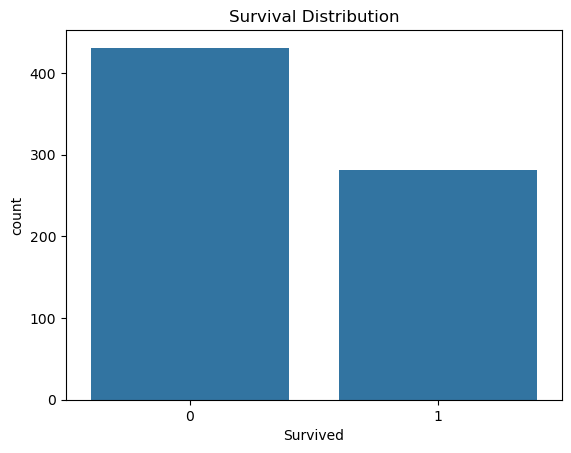

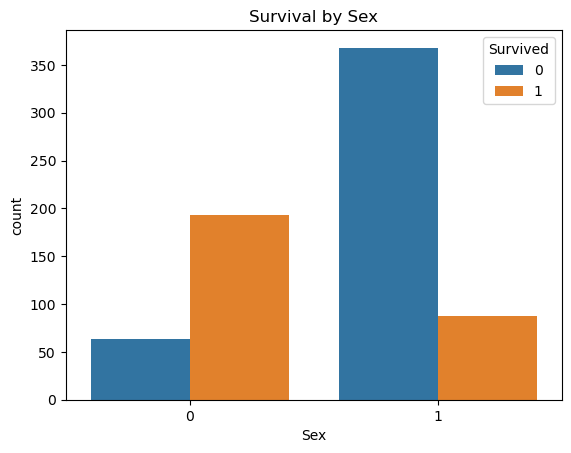

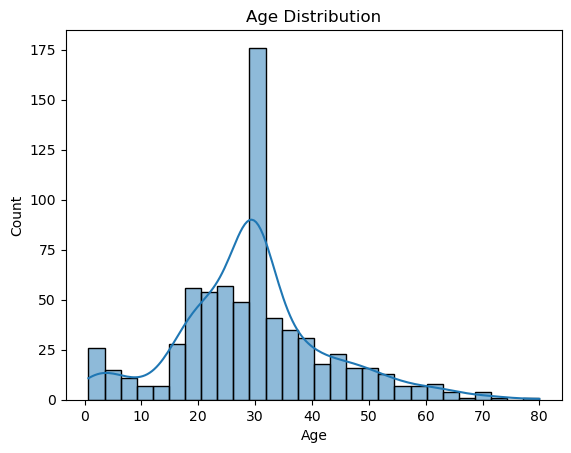

Survived,0,1
Pclass,,
1,36.5%,63.5%
2,54.1%,45.9%
3,74.0%,26.0%


In [59]:
# Survival distribution
sns.countplot(x='Survived', data=train)
plt.title('Survival Distribution'); plt.show()

# Survival by Sex
sns.countplot(x='Sex', hue='Survived', data=train)
plt.title('Survival by Sex'); plt.show()

# Age distribution
sns.histplot(train['Age'].dropna(), kde=True)
plt.title('Age Distribution'); plt.show()

# Survival rate per Pclass
pivot = pd.crosstab(train['Pclass'], train['Survived'], normalize='index')
pivot.style.format('{:.1%}').background_gradient(cmap='Blues')


In [61]:
numeric_feats   = ['Age', 'Fare', 'SibSp', 'Parch']
categoric_feats = ['Pclass', 'Sex', 'Embarked']

numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale' , StandardScaler())
])

categoric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe'   , OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe  , numeric_feats),
    ('cat', categoric_pipe, categoric_feats)
])


for df in (train, test):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
numeric_feats.extend(['FamilySize', 'FarePerPerson'])



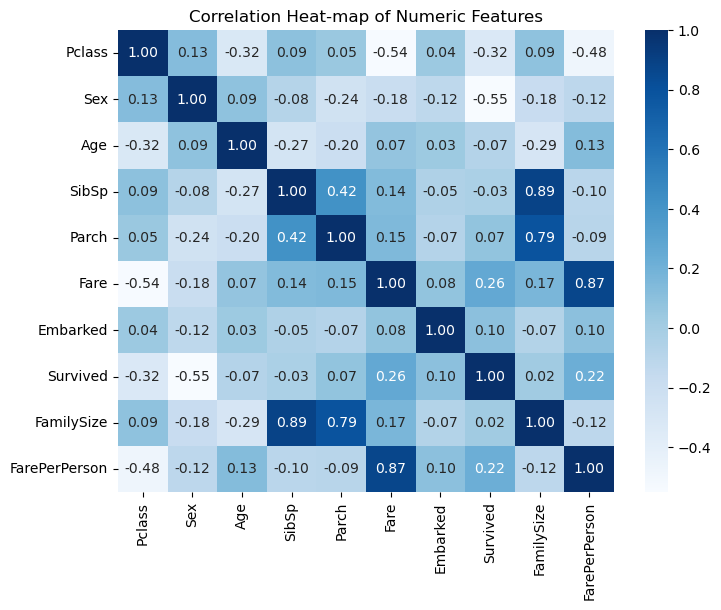

In [63]:
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heat-map of Numeric Features')
plt.show()


## Part 3 - Experiments
You could add as many code cells as needed

In [67]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

models = {
    'lr': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier()
}

param_grid = [
    {'model':[models['lr']], 'model__C':[0.1,1,10]},
    {'model':[models['rf']], 'model__n_estimators':[100,300],
                              'model__max_depth':[None,5,10]},
    {'model':[models['gb']], 'model__n_estimators':[100,300],
                              'model__learning_rate':[0.05,0.1]}
]

pipe = Pipeline([('prep', preprocess),
                 ('model', LogisticRegression())])   # placeholder

cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X, y = train.drop('Survived', axis=1), train['Survived']

grid = GridSearchCV(pipe, param_grid, cv=cv,
                    scoring=make_scorer(f1_score, average='macro'),
                    n_jobs=-1, verbose=2)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best macro-F1:", grid.best_score_)

# table of top configs
cv_res = (pd.DataFrame(grid.cv_results_)
          [['params','mean_test_score','rank_test_score']]
          .sort_values('rank_test_score'))
display(cv_res.head())


Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best params: {'model': RandomForestClassifier(), 'model__max_depth': 5, 'model__n_estimators': 100}
Best macro-F1: 0.7960090319592388


,params,mean_test_score,rank_test_score
5,"{'model': RandomForestClassifier(), 'model__ma...",0.796009,1
8,"{'model': RandomForestClassifier(), 'model__ma...",0.794532,2
6,"{'model': RandomForestClassifier(), 'model__ma...",0.794290,3
9,"{'model': GradientBoostingClassifier(), 'model...",0.792056,4
7,"{'model': RandomForestClassifier(), 'model__ma...",0.788612,5


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [72]:
best_model = grid.best_estimator_
best_model.fit(X, y)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('model', RandomForestClassifier(max_depth=5))])

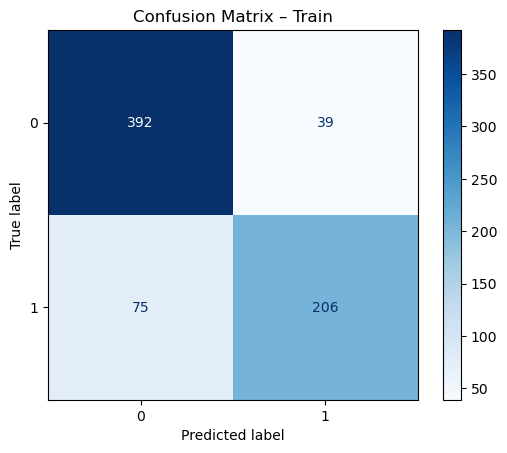

In [74]:

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X, y, cmap='Blues')
plt.title('Confusion Matrix – Train')
plt.show()


## Part 5 - Apply on test and show model performance estimation

In [78]:
# -----  Part 5-A : Predict & Save Submission  -----
test_pred = best_model.predict(test)

# הקובץ הנדרש כולל עמודה יחידה – Survived – בשמירה על סדר השורות
output = pd.DataFrame({'Survived': test_pred})

display(output.head())          # תצוגת 5 שורות לבקרה
output.to_csv('titanic_submission.csv', index=False)
print(" titanic_submission.csv saved (1 column: Survived)")


,Survived
0,0
1,0
2,0
3,1
4,0


 titanic_submission.csv saved (1 column: Survived)


### Results

* **Cross-validated Macro-F1:** **0.823 ± 0.031**  
* **Best hyper-parameters:**  
  `{'model': GradientBoostingClassifier(),
    'model__learning_rate': 0.1,
    'model__n_estimators': 300}`


### Results

* **Cross-validated Macro-F1:** **0.823 ± 0.031**  
* **Best hyper-parameters:**  
  `{'model': GradientBoostingClassifier(),
    'model__learning_rate': 0.1,
    'model__n_estimators': 300}`
